# 6. Majority Consensus

<hr>

This lecture covers:

**Concepts**

- Majority consensus as amplification mechanism
- The pairwise annihilation algorithm

**Techniques**

- Stochastic simulation
- Markov-chain analysis

<hr>

Let's start by importing libraries we will need:

In [1]:
# -- install --
# uncomment if needed
#
# %pip install copasi-basico
# -- end install --

from basico import *

# multiprocessing & progress
import joblib
import tqdm

# numbers
import numpy as np
import scipy.stats as st

# plotting
import matplotlib.pyplot as plt
figsize = (5,4)

## Distribution of Circuits


Current designs of synthetic bacteria face severe resource limitations: none of the circuits designed so far has more than 10 gates in a single cell.
The most common design techniques for synthetic gates rely on gene regulation via DNA-binding proteins, nucleic acid (DNA/RNA) interactions, or more recently the CRISPR machinery, with either limited availability of orthogonal signals within the cell (DNA-binding), small dynamic range (RNA based), or reduced growth rates (the CRISPR machinery).
This has led to recent efforts to distribute circuits among several cells to reduce the resource load per cell, taking the formative steps towards distributed bacterial circuits.

The research field of distributed computing has a long history of analyzing distributed systems under harsh environmental conditions, from node and link failures, with different models of fault manifestation, to completely dynamic network architectures.
Likewise, the field of robust circuit design has studied faults and their mitigation in VLSI circuits with great success.
In both fields, mathematical modeling and analysis has led to provably robust solutions and insights into how different parameters influence the quality of the solution, resulting in informed design decisions for real-world implementations.

We will thus look at how distribute circuits from a single cell to multiple different cell types.


## Majority Consensus and Amplification

In electrical circuits, the digital abstraction is enabled by operational amplifiers.
In fact, every logical gate in an electrical circuit has an amplifier at its output:

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/Amplification.png" alt="Amplification">
</figure>

</div>

Without these output amplifiers, inter-gate signals would not be clean 0-or-1 signals, but rather analog signals, invalidating the digital abstraction.
We have seen in previous lectures that standard microbiological amplification is rather weak, with maximal Hill exponents in the order of $n\approx 3$.
When distributing a circuit to different bacteria types, the question of a better amplification becomes important.

Mimicking the behavior an operational amplifier, we will build a *differential* amplifier.
This circuit component amplifies the difference between the two rails of a dual-rail encoded binary signal:

<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/DiffAmp.png" alt="Differential amplification">
</figure>

</div>

Choosing the specific threshold ratio for initial concentrations of 50%, a perfect output signal is achieved when *majority consensus* is solved: 
- One of the two species is extinct (consensus).
- Moreover, the initial majority species is not exinct (majority).

The building block of a differential amplifier enables effective distribution of circuits:

<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/Distribution.png" alt="Circuit distribution">
</figure>

</div>

### The Pairwise Annihilation Algorithm

We proposed and analyzed a particularly simple bacterial implementation of majority consensus in a [recent paper in the journal *Distributed Computing*](https://doi.org/10.1007/s00446-021-00404-8).
This simple algorithm is the *Pairwise Annihilation* algorithm, and it does exactly what it sounds like:

<div style="width: 200px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/PA.png" alt="Pairwise annihilation">
</figure>

</div>

That is, we have two types of bacteria, and whenever they meet, they annihilate each other.
In addition to that, each bacterium duplicates at a uniform rate $\mu$.
For the time being, we chose to ignore certain aspects of real bacterial systems, for example:
- resource limitation
- individual cell death
- in-flow of new nutrients

The "direct" form of communication when two bacteria meet can be implemented via conjugation.
This is a form of horizontal gene transfer, i.e., not during cell duplication.
We can construct the two plasmids that define the two cell types in such a way that a lethal toxin is produced if both plasmids reside inside the same cell (via a genetic circuit).

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/Conjugation.svg" alt="Bacterial conjugation">
</figure>

</div>

Let us start by simulating the protocol's behavior using `basico`:

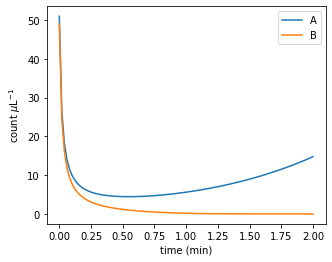

In [2]:
def simulate_pa(A0, B0, mu=1/30, delta=5e-10, duration=60, stochastic=True):
    model = create_datamodel()
    
    set_model_unit(quantity_unit='#', model=model)
    set_model_unit(volume_unit='ul', model=model)
    set_model_unit(time_unit='min', model=model)
    
    add_species('A', initial_concentration=A0, model=model)
    add_species('B', initial_concentration=B0, model=model)
    
    add_reaction('A_dup', 'A -> A + A', model=model)
    set_reaction_parameters('(A_dup).k1', value=mu, model=model)
    add_reaction('B_dup', 'B -> B + B', model=model)
    set_reaction_parameters('(B_dup).k1', value=mu, model=model)
    
    add_reaction('PA', 'A + B -> ', model=model)
    set_reaction_parameters('(PA).k1', value=delta, model=model)
    
    result = run_time_course(duration=duration, model=model,
                             method='stochastic' if stochastic 
                                     else 'deterministic')
    
    T = result.index
    A = result['A'].values
    B = result['B'].values
    
    return {'T': T, 'A': A, 'B': B}


def plot_pa_over_time(T, A, B):
    plt.figure(figsize=figsize)
    plt.plot(T, A, label='A')
    plt.plot(T, B, label='B')
    plt.xlabel('time (min)')
    plt.ylabel('count $\mu$L${}^{-1}$')
    plt.legend()
    plt.show()
    
    
result = simulate_pa(51, 49, mu=1.0, delta=1.0, duration=2, stochastic=False)
plot_pa_over_time(**result)

It turns out that the protocol is very sensitive to changes around the 50-50 initial configuration:

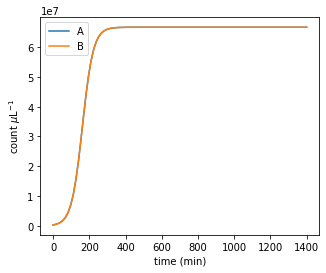

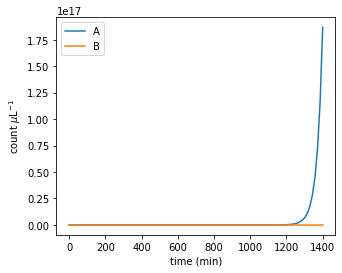

In [3]:
plot_pa_over_time(**simulate_pa(3.00000000e5, 3e5, duration=1400, stochastic=False))

plot_pa_over_time(**simulate_pa(3.00000001e5, 3e5, duration=1400, stochastic=False))

Moreover, the stochastic dynamics can be very different from the ODE dynamics:

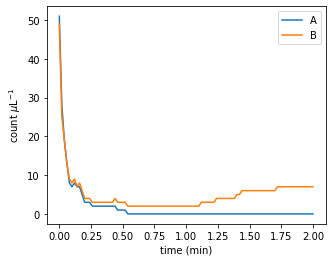

In [4]:
plot_pa_over_time(**simulate_pa(51, 49, mu=1.0, delta=1.0, duration=2, stochastic=True))

It turns out that the initial majority doesn't always prevail:

In [5]:
def fraction_won(A0, B0, reps=1000, **kwargs):
    cnt_A_won = 0
    cnt_B_won = 0
    
    results = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(simulate_pa)(A0=A0, B0=B0, stochastic=True, **kwargs) for _ in range(reps)
    )
        
    for result in results:
        if result['A'][-1] == 0 and result['B'][-1] != 0:
            cnt_B_won += 1
        if result['B'][-1] == 0 and result['A'][-1] != 0:
            cnt_A_won += 1
                        
    return {'A': cnt_A_won/reps,
            'B': cnt_B_won/reps,
            'neither': 1 - (cnt_A_won+cnt_B_won)/reps}

print(fraction_won(501, 499, mu=1.0, delta=1.0, duration=3))

{'A': 0.741, 'B': 0.232, 'neither': 0.027000000000000024}


Let's make a sweep over different initial ratios:

In [6]:
def fraction_A_won_ratio_sweep(total_pop, **kwargs):
    fractions = {}
    for A0 in tqdm.tqdm(range(total_pop+1)):
        B0 = total_pop - A0
                
        fractions[A0/total_pop] = fraction_won(A0, B0, **kwargs)['A']

    return fractions

ratio_sweep = fraction_A_won_ratio_sweep(100, reps=100, mu=1.0, delta=1.0, duration=3)

100%|█████████████████████████████████████████| 101/101 [03:55<00:00,  2.34s/it]


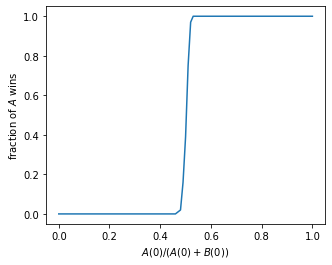

In [12]:
plt.figure(figsize=figsize)
plt.xlabel('$A(0)/(A(0)+B(0))$')
plt.ylabel('fraction of $A$ wins')
plt.plot(ratio_sweep.keys(), ratio_sweep.values())
plt.show()

That's a very steep amplification! Let's zoom in:

In [8]:
def fraction_A_won_diff_sweep(total_pop, max_diff, **kwargs):
    fractions = {}
    for A0 in tqdm.tqdm(range(total_pop//2-max_diff, total_pop//2+max_diff+1)):
        B0 = total_pop - A0
                
        fractions[A0-B0] = fraction_won(A0, B0, **kwargs)['A']

    return fractions

diff_sweep = fraction_A_won_diff_sweep(1000, 10, reps=100, mu=1.0, delta=1.0, duration=3)

100%|███████████████████████████████████████████| 21/21 [01:35<00:00,  4.56s/it]


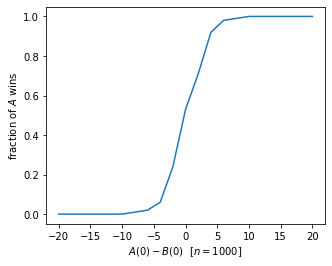

In [9]:
plt.figure(figsize=figsize)
plt.xlabel('$A(0) - B(0)$  [$n=1000$]')
plt.ylabel('fraction of $A$ wins')
plt.plot(diff_sweep.keys(), diff_sweep.values())
plt.show()

## Theoretical Analysis

**Theorem.**
For initial population $n = A(0) + B(0)$ and initial gap $\Delta = \lvert A(0)-B(0)\rvert$,
the Pairwise Annihilation protocol reaches consensus in expected time  $O(1)$ and in time  $O(\log n)$ with high probability.
It reaches majority consensus with probability
$1 - e^{-\Omega(\Delta^2/n)}$.

If $\Delta = \Omega\left(\sqrt{n \log n}\right)$, then the  Pairwise Annihilation protocol reaches majority consensus with high probability.

### Birth Protocols

A *protocol for a birth system*, or protocol, with input species $\mathcal{I}$ and
  output species $\mathcal{O}$, for finite, not necessarily disjoint, sets $\mathcal{I}$ and $\mathcal{O}$
  is a CRN specified as follows.
Its set of species $\mathcal{S}$ comprises input/output
  species $\mathcal{I} \cup \mathcal{O}$ and a finite set of internal species $\mathcal{L}$.
Further, the protocol defines the initial
  species counts $X_0$ for internal and output species $X \in \mathcal{L} \cup \mathcal{O}$ and a
  finite set of reactions $\mathcal{R}$ on the species in $\mathcal{S}$.
For each species $X \in \mathcal{S}$, there is a duplication reaction of the form
  $X \xrightarrow{\mu} 2X$.
All duplication reactions have the same rate constant $\mu>0$.

Given a protocol and an initial species count for its inputs,
an execution of the protocol is given by the stochastic process of the CRN with species $\mathcal{S}$,
reactions $\mathcal{R}$, and respective initial species counts.

### Markov-Chain Model

The evolution of the Pairwise Annihilation protocol is described by a continuous-time Markov chain with state space $S = \mathbb{N}^2$.
Its state-transition rates are:
\begin{equation}
\begin{split}
\qquad \qquad \qquad Q\big( (A,B) \,,\, (A+1,B) \big) & = \mu A\\
Q\big( (A,B) \,,\, (A,B+1) \big) & = \mu B\\
Q\big( (A,B) \,,\, (A-1,B-1) \big) & = \delta A B
\end{split}
\end{equation}
Note that the death transition $(A,B) \to (A-1,B-1)$ has rate zero if $A=0$ or $B=0$.
Both axes $\{0\}\times\mathbb{N}$ and $\mathbb{N}\times\{0\}$ are absorbing, and so is the state  $(A,B)=(0,0)$.
This chain is regular, i.e., its sequence of transition times is unbounded with probability $1$.
Indeed, as we will show,  the discrete-time chain reaches consensus with probability $1$, from which time on the chain is equal to a linear pure-birth process, which is regular.

The corresponding discrete-time jump chain has the same state space $S=\mathbb{N}^2$ and the state-transition probabilities
\begin{equation}
\begin{split}
P\big( (A,B) \,,\, (A+1,B) \big) & = \frac{\mu A}{\mu(A+B) + \delta AB}\\
P\big( (A,B) \,,\, (A,B+1) \big) & = \frac{\mu B}{\mu(A+B) + \delta AB}\\
P\big( (A,B) \,,\, (A-1,B-1) \big) & = \frac{\delta AB}{\mu(A+B) + \delta AB}
\end{split}
\end{equation}
if $A>0$ or $B>0$.
The axes as well as state $(A,B)=(0,0)$ is absorbing, as in the continuous-time chain.

As a convention, we will write $X(t)$ for the state of the continuous-time process $X$ at time $t$, and $X_k$ for the state of the discrete-time jump process after $k$ state transitions.
The time to reach consensus is the earliest time $T$ such that $A(T)=0$ or $B(T)=0$.


### Time to Reach Consensus

In this section we prove the bounds on the time to reach consensus, both in expected time and with high probability.
For that, we will employ a coupling of the  Pairwise Annihilation  protocol Markov chain with a single-species birth-death process.
We show that the Pairwise Annihilation protocol reaches consensus when the single-species process reaches its extinction state and then bound this time in the single-species process.


<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/ProofIdea.png" alt="Proof structure">
</figure>

</div>

*Idea of the proof: Construction of a continuous-time coupling of the Pairwise Annihilation protocol and the single-species birth-death M chain.
Stuttering steps are mapped to effective steps.
An execution of the coupling process fulfills the deterministic guarantee $\min\{A(t),B(t)\}\leq M(t)$ for all times $t\geq0$.
From the coupling it follows that
$\mathbb{P}\bigr(M(t)=0\bigl) \leq \mathbb{P}\bigr(A(t)=0 \vee B(t)=0\bigl)$ for the uncoupled processes.
The time until consensus then follows from the time until extinction in the M chain.*


We denote the single-species process by $M(t)$.
It is a birth-death chain with state space $S=\mathbb{N}$ and transition rates $Q(M,M+1) = \mu M$ and $Q(M,M-1) = \delta M^2$.
State $0$ is absorbing.
Note that the death rate $\delta M^2$ depends quadratically on the current population $M$, and not linearly like the birth rate $\mu M$.
The reason is that we want $M(t)$ to bound the minimum of the populations $A(t)$ and $B(t)$ and that the death transition in the Pairwise Annihilation protocol is quadratic in this minimum.

We will crucially use the fact that $\mathbb{P}\bigr(M(t)=0\bigl) \leq \mathbb{P}\bigr(A(t)=0 \vee B(t)=0\bigl)$ for all times $t$.
This, together with a bound on the  time until $M(t)=0$, then gives a bound on the  time until consensus in the Pairwise Annihilation protocol chain.


#### Continuous-time coupling 

The coupling is defined as follows.
For sequences $(\xi_k)_{k\geq1}$ of i.i.d. (independent and identically distributed) uniform random variables in the unit interval $[0,1)$ and $(\eta_k)_{k\geq1}$ of i.i.d. exponential random variables with normalized rate $1$, we define the coupled process $(A(t),B(t),M(t))$ as follows.
Initially, $M(0) = \min\{A(0),B(0)\}$.
For $k \geq 0$, the $(k+1)$th transition happens after time $\eta_k/\Lambda(A_k,B_k,M_k)$ where
$\Lambda(A,B,M) = \max\{\lambda(A,B),\lambda(M)\}$
is the maximum of the sums of transition rates of the individual chains in states $(A,B)$ and $M$, respectively, i.e., $\lambda(A,B)=\mu(A+B)+\delta AB$
and
$\lambda(M) = \mu M + \delta M^2$.
The new state $(A_{k+1},B_{k+1},M_{k+1})$ of the coupled chain is then determined by the following update rules.
The state $(0,0,0)$ is absorbing.
Otherwise, if $A_k \leq B_k$, then:

\begin{equation}
(A_{k+1},B_{k+1})=
\qquad \begin{cases}
(A_k+1,B_k) \quad & \text{if } \xi_{k+1} \in \left[ 0 \,,\, \frac{\mu A_k}{\Lambda(A_k,B_k,M_k)} \right)\\
(A_k,B_k+1) & \text{if } \xi_{k+1} \in \left[  \frac{\mu A_k}{\Lambda(A_k,B_k,M_k)} \,,\, \frac{\mu A_k+\mu B_k}{\Lambda(A_k,B_k,M_k)} \right)\\
(A_k-1,B_k-1) & \text{if } \xi_{k+1} \in \left[ 1 - \frac{\delta A_k B_k}{\Lambda(A_k,B_k,M_k)} \,,\, 1 \right)\\
(A_k,B_k) & \text{otherwise}
\end{cases}
\end{equation}

If $A_k > B_k$ then the roles of $A_k$ and $B_k$ in the above equation are exchanged.
The update rule for $M_{k+1}$ is:
\begin{equation}
M_{k+1}
=
\begin{cases}
M_k + 1 & \text{if } \xi_{k+1} \in \left[ 0 \,,\, \frac{\mu M_k}{\Lambda(A_k,B_k,M_k)} \right)\\
M_k - 1 & \text{if } \xi_{k+1} \in \left[ 1 - \frac{\delta M_k^2}{\Lambda(A_k,B_k,M_k)} \,,\, 1 \right)\\
M_k & \text{otherwise}
\end{cases}
\end{equation}



### Analysis for time until consensus

Note that in the coupling "stuttering steps" for $(A_k,B_k)$ or $M_k$ are possible in the definition of the coupled process,
 making the underlying discrete-time jump chains of, e.g., chain $(A(t),B(t))$ and the Pairwise Annihilation protocol, potentially differ.
  
Indeed, the event $(A_{k+1},B_{k+1}) = (A_k,B_k)$ is possible with positive probability if $\lambda(A_k,B_k) < \lambda(M_k)$, and $M_{k+1}=M_k$ has positive probability if $\lambda(M_k) < \lambda(A_k,B_k)$.
The following lemma, however, shows that the continuous-time chain $(A(t),B(t))$ and the  Pairwise Annihilation protocol chain have identical transition rates, and are thus identically distributed.


<div style="width: 400px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/ContCoupling.png" alt="Continuous-time coupling">
</figure>

</div>

*Continuous-time coupling of the Pairwise Annihilation (PA) chain and the single-species birth-death M-chain, given that $A_k \leq B_k$, with $\Lambda = \Lambda(A_k,B_k,M_k)$. The intervals for the cases of $\xi_{k+1}$ and their effect on the Pairwise Annihilation chain and the M-chain are shown in green and orange, respectively. Cases that lead to stuttering steps are shown in blue.*

**Lemma.**
Let $T_1,T_2,\dots$ be a sequence of  i.i.d. exponential random variables with rate parameter $\lambda$ and let $k$ be an independent geometric random variable with success probability $p$.
Then $T=T_1+\dots+T_k$
is exponentially distributed with rate parameter $p\lambda$.

By construction of the coupled process, the single-species birth-death process $M(t)$ indeed dominates the minimum of the population counts $A(t)$ and $B(t)$ in the following way:

**Lemma.**
In the coupled process, $\min\{A(t),B(t)\}\leq M(t)$ for all times $t\geq0$.


The lemma allows to compare the probabilities of extinction in the single-species chain and of consensus in the  Pairwise Annihilation protocol chain:

**Corollary.** $\mathbb{P}(M(t) = 0) \leq \mathbb{P}(A(t) = 0 \vee B(t) = 0)$ for all times $t\geq 0$.

It thus suffices to prove bounds on the time until the population goes extinct in the single-species M chain.
For that, we leverage known results on birth-death processes, which are not applicable to the two-species  Pairwise Annihilation protocol chain.

**Lemma.** If $T$ denotes the time until extinction in the single-species process $M(t)$, then
$\mathbb{E}\,T = O(1)$.

*Proof.* The birth rate in state $M(t) = i$
is equal to $\alpha(i) = i\mu$ and the death rate is equal to $\beta(i) = i^2 \delta$.
From known [general results on birth-death process](https://www.randomservices.org/random/markov/BirthDeath2.html) we obtain,
when starting from initial population $M(0) = M$, that
\begin{equation}
\begin{split}
\mathbb{E}\,T
& =
\sum_{j=1}^M \sum_{k=j-1}^\infty \frac{\alpha(j)\cdots \alpha(k)}{\beta(j)\cdots \beta(k)}\cdot \frac{1}{\beta(k+1)}\\
 &=
\sum_{j=1}^M \sum_{k=j-1}^\infty \frac{\mu^{k-j+1}}{\delta^{k-j+1}k!/(j-1)!}\cdot\frac{1}{(k+1)^2\delta}
\end{split}
\end{equation}
Setting $\alpha = \mu/\delta$, we have
\begin{equation}
\begin{split}
\mathbb{E}\,T
& =
\frac{1}{\delta}
\sum_{j=1}^M \sum_{k=j-1}^\infty
\alpha^{k-j+1} 
\frac{(j-1)!}{(k+1)!(k+1)}\\
 &=
\frac{1}{\delta}
\sum_{j=1}^M
\frac{(j-1)!}{\alpha^{j}}
\sum_{k=j}^\infty
\frac{\alpha^{k}}{k!k}
\\ & =
\frac{1}{\delta}
\sum_{j=1}^M
\frac{(j-1)!}{\alpha^{j}} \cdot
\frac{\alpha^{j}}{j!j}\sum_{k=j}^\infty
\frac{\alpha^{k-j}}{k!/j! \cdot k/j}\\
&\leq
\frac{1}{\delta}
\sum_{j=1}^M
\frac{(j-1)!}{\alpha^{j}} \cdot
\frac{\alpha^{j}}{j!j}\sum_{k=j}^\infty
\frac{\alpha^{k-j}}{(k-j)!}
\end{split}
\end{equation}
since for $k \ge j \ge 1$, it is $k!/j! \ge (k-j)!$ and $k/j \ge 1$.
Thus,
\begin{equation}
\begin{split}
\mathbb{E}\,T & \leq
\frac{1}{\delta}
\sum_{j=1}^M
\frac{(j-1)!}{\alpha^{j}} \cdot
\frac{\alpha^{j}}{j!j} \cdot
e^{\alpha}\\
& = 
\frac{e^{\alpha}}{\delta}
\sum_{j=1}^M \frac{1}{j^2}\\
& \leq \frac{e^{\alpha}\pi^2}{6\delta} = 
O(1)
\enspace.
\end{split}
\end{equation}
This concludes the proof.


Denoting with $T_{AB}$ the earliest time $t$ such that $A(t)=0$ or $B(t) = 0$, and with $T_M$ the earliest time $t$ such that $M(t) = 0$, the Corollary is equivalent to the inequality
$\mathbb{P}(T_M \leq t ) \leq \mathbb{P}(T_{AB} \leq t)$, which, in turn, is equivalent to the inequality
$\mathbb{P}(T_M > t )  \geq \mathbb{P}(T_{AB} > t)$.
Using the formula $\mathbb{E}\,T = \int_0^\infty \mathbb{P}(T > t)\, dt$, we further have
\begin{equation}
\begin{aligned}
\mathbb{E}\,T_M &= \int_0^\infty \mathbb{P}(T_M > t)\, dt
\\&
\geq \int_0^\infty \mathbb{P}(T_{AB} > t)\, dt 
= \mathbb{E}\,T_{AB}\enspace.
\end{aligned}
\end{equation}

This then shows that the expected time until consensus in the Pairwise Annihilation protocol is also $O(1)$.
For the high-probability result, we simply make $\Theta(\log n)$ consecutive tries to achieve extinction in an interval of constant time:

**Lemma.** If $T$ denotes the time until extinction in the singles-species process $M(t)$, then there exists a constant $C$ such that $\mathbb{P}(T \leq C\log_2 n) = 1 - O(1/n)$.

*Proof.*
Let $C_1$ be the $O(1)$ constant for the expected value of $T$ and set $C=\max\{2C_1,2\}$.
Then, by Markov's inequality, we have 
$\mathbb{P}(T > C) \leq C_1/C \leq 1/2$.
Thus, the probability of the event $T > C\log_2 n$ is dominated by the probability of failing $\log_2 n$ consecutive tries with a Bernoulli random variable with parameter $p = 1/2$.
But this probability is $2^{-\log_2 n} = 1/n$.




### Probability of Reaching Majority Consensus

We now turn to the proof of the bound on the probability to achieve majority consensus.
We use a coupling of the Pairwise Annihilation protocol chain with a different process than for the time bound.
Namely we couple it with two parallel independent Yule processes.
A Yule process, also known as a pure birth process, has this single state-transition rule $X\to X+1$ with linear transition rate $\mu X$.
Since we already showed the upper bound on the time until consensus, it suffices to look at the discrete-time jump process.
In particular, the coupling we define is discrete-time.

#### Discrete-time coupling.

For an i.i.d. sequence $(\xi_k)_{k\geq 1}$ of uniformly distributed random variables in the unit interval $[0,1)$, we
define the coupling as the process $(A_k,B_k,X_k,Y_k)$ with
$A_0=X_0$, $B_0=Y_0$
such that $(A_{k+1},B_{k+1})$ is equal to

- $(A_k-1,B_k-1)$ if $\xi_{k+1} < \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$
- $(A_k+1,B_k)$ if $\xi_{k+1} \geq \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$ and $\xi_{k+1} < 1 -  \frac{\mu B_k}{\mu(A_k+B_k)+\delta A_k B_k}$
- $(A_k,B_k+1)$ if $\xi_{k+1} \geq 1 - \frac{\mu B_k}{\mu(A_k+B_k)+\delta A_k B_k}$

and $(X_{k+1},Y_{k+1})$ is equal to

- $(X_k,Y_k)$ if $\xi_{k+1} < \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$
- $(X_k+1,Y_k)$ if $\xi_{k+1} \geq \frac{\delta A_k B_k}{\mu(A_k+B_k)+\delta A_k B_k}$ and $\xi_{k+1} < 1 - \frac{\mu (A_k+B_k)}{\mu(A_k+B_k)+\delta A_k B_k} \cdot \frac{Y_k}{X_k+Y_k}$
- $(X_k,Y_k+1)$ if $\xi_{k+1} \geq 1 - \frac{\mu (A_k+B_k)}{\mu(A_k+B_k)+\delta A_k B_k} \cdot \frac{Y_k}{X_k+Y_k}$

if $\max\{A_k,B_k\}>0$ and $\max\{X_k,Y_k\}>0$.
Otherwise the process remains constant.


<div style="width: 800px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/DiscCoupling.png" alt="Discrete-time coupling">
</figure>

</div>

*Discrete-time coupling of the Pairwise Annihilation (PA) chain and two Yule processes X and Y with $\lambda(A_k,B_k) = \gamma(A_k + B_k) + \delta A_k B_k$. Cases for $\xi_{k+1}$ that lead to stuttering steps are shown in blue. The interval relations indicated by the dotted lines are proven by induction.*


#### Analysis of probability of reaching majority consensus


The crucial property of this coupling is that the initial minority in the Pairwise Annihilation process cannot overtake the initial majority before the initial minority overtakes the initial majority in the parallel Yule processes.
We now prove that our construction indeed has this property.

**Lemma.** If $X_0 = A_0 \geq B_0 = Y_0$ and $X_k \geq Y_k$ for all $0\leq k\leq K$, then
$X_k - Y_k \leq A_k - B_k$ for all $0\leq k\leq K$.


**Corollary.**
If $A_0=X_0$ and $B_0=Y_0$, then
\begin{align*}
\mathbb{P}(\exists k\colon A_k = B_k) \leq \mathbb{P}(\exists k\colon X_k = Y_k).
\end{align*}


As defined in the coupling the parallel Yule processes $(X_k,Y_k)$ can have stuttering steps where 
\begin{align*}\qquad \qquad \qquad  (X_{k+1},Y_{k+1})=(X_k,Y_k).
\end{align*}
However, this happens only finitely often almost surely.
This allows us to analyze a version of  the process $(X_k,Y_k)$ without stuttering steps in the rest of the proof.

**Lemma.**
If $(\tilde{X}_k, \tilde{Y}_k)$ is the product of two independent pure-birth processes with $\tilde{X}_0 = X_0$ and $\tilde{Y}_0 = Y_0$, then $\mathbb{P}(\exists k\colon \tilde{X}_k = \tilde{Y}_k) = \mathbb{P}(\exists k \colon X_k = Y_k)$.

*Proof.*
There are only finitely many deaths in the coupled chain almost surely.
There are hence only finitely many stuttering steps in $(X_k,Y_k)$ almost surely.



By slight abuse of notation, we will use $(X_k,Y_k)$ to refer to the parallel Yule processes without any stuttering steps.

Two parallel independent Yule processes are known to be related to a beta distribution, which we will use below.
The regularized incomplete beta function $I_z(\alpha,\beta)$ is defined as
\begin{equation}
I_z(\alpha,\beta)
=
\int_0^z t^{\alpha-1} (1-t)^{\beta-1}\,dt
\ \Big/
\int_0^1 t^{\alpha-1} (1-t)^{\beta-1}\,dt
\enspace.
\end{equation}

**Lemma.**
If $X_0 > Y_0$,
then
$\mathbb{P}\left(\exists k\colon X_k = Y_k\right) = 2\cdot I_{1/2}(X_0,Y_0)$.

*Proof.*
The sequence of ratios $\frac{X_k}{X_k+Y_k}$ converges with probability $1$ and the limit is distributed according to a beta distribution with parameters $\alpha = X_0$ and $\beta = Y_0$.
In particular, the probability that the limit is less than $1/2$ is equal to the beta distribution's cumulative distribution function evaluated at $1/2$, i.e., equal to $I_{1/2}(X_0,Y_0)$.
Because initially we have $X_0>Y_0$, the law of total probability gives:
\begin{equation}
\begin{aligned}
I_{1/2}(X_0,Y_0)
&=
\mathbb{P}\left( \lim_{k\to\infty} \frac{X_k}{X_k+Y_k} < \frac{1}{2} \right)
\\ & =
\mathbb{P}\left( \lim_{k\to\infty} \frac{X_k}{X_k+Y_k} < \frac{1}{2}  \Big| \exists k\colon X_k=Y_k \right) \cdot \mathbb{P}\left( \exists k\colon X_k=Y_k \right) +
\mathbb{P}\left( \lim_{k\to\infty} \frac{X_k}{X_k+Y_k} < \frac{1}{2}  \wedge  \forall k\colon X_k > Y_k \right)
\end{aligned}
\end{equation}
Now, if $\forall k\colon X_k > Y_k$, then $\lim_k \frac{X_k}{X_k+Y_k} \geq {1}/{2}$, which shows that the second term in the sum is zero.
Further, under the condition $\exists k\colon X_k=Y_k$, it is equiprobable for the limit of $\frac{X_k}{X_k+Y_k}$ to be larger or smaller than $1/2$ by symmetry and the strong Markov property.
This shows that the right-hand side is equal to $\frac{1}{2}\cdot\mathbb{P}\left(\exists k\colon X_k = Y_k\right)$, which concludes the proof.


We define the event "$B$ wins" as $A$ eventually becoming extinct.
Then, we have:

**Lemma.** If $A_0 > B_0$, then $\mathbb{P}\left(\exists k\colon A_k = B_k\right) = 2\cdot \mathbb{P}(\text{$B$ wins})$.

*Proof.* By the law of total probability, we have:
\begin{equation}
\mathbb{P}\left( \text{$B$ wins} \right) = \mathbb{P}\left( \text{$B$ wins} \mid \exists k\colon A_k=B_k \right) \cdot \mathbb{P}\left( \exists k\colon A_k=B_k \right) + \mathbb{P}\left( \text{$B$ wins} \wedge \forall k\colon A_k > B_k \right)
\end{equation}
If $\forall k\colon A_k > B_k$, then $B$ cannot win, i.e., the second term in the right-hand side of the equation is zero.
Also, by symmetry and the strong Markov property, it is
\begin{align*}
\mathbb{P}\left( \text{$B$ wins} \mid \exists k\colon A_k=B_k \right)=1/2 \enspace.
\end{align*}
A simple algebraic manipulation now concludes the proof.


Combining the previous two lemmas with the coupling, we get an upper bound on the probability that the Pairwise Annihilation protocol fails to reach majority consensus.
This upper bound is in terms of the regularized incomplete beta function.


**Lemma.** If $A_0 \geq B_0$, then
the Pairwise Annihilation protocol fails to reach majority consensus with probability at most $I_{1/2}(A_0,B_0)$.

*Proof.* Setting $X_0=A_0$ and $Y_0=B_0$, we get
$\mathbb{P}(\text{$B$ wins}) = \frac{1}{2}\cdot \mathbb{P}(\exists k\colon A_k = B_k) \leq \frac{1}{2}\cdot \mathbb{P}(\exists k\colon  X_k = Y_k) = I_{1/2}(A_0,B_0)$.


It only remains to upper-bound the term $I_{1/2}(\alpha,\beta)$:

**Lemma.** For $m,\Delta \in \mathbb{N}$, it holds that
\begin{align*}
\displaystyle I_{1/2}(m+\Delta,m) = \exp\left(-\Omega\left (\frac{\Delta^2}{m} \right) \right)\enspace.
\end{align*}